## Introduction

This notebook is adapted from k-means notebooks from Dr. Kevin Murphy's [pyprobml](https://github.com/probml/pyprobml) repo and python code from [ML from scratch](https://www.python-engineer.com/courses/mlfromscratch/12_kmeans/).

In [44]:
# K-means clustering in 2d
# Code is based on  chapter 9 of
# https://github.com/ageron/handson-ml2


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colormaps

# To plot pretty figures
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

try:
    from sklearn.datasets import make_blobs
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Data

In [45]:
geron_data = False;

if geron_data:
    blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
    blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
    X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)
else:
    # two off-diagonal blobs
    X1, _ = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
    X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
    # three spherical blobs
    blob_centers = np.array([[-4, 1], [-4, 3], [-4, -2]])
    s = 0.5
    blob_std = np.array([s, s, s])
    X2, _ = make_blobs(n_samples=1000, centers=blob_centers, cluster_std=blob_std, random_state=7)
    # 5 blobs in total
    X = np.r_[X1, X2]

X.shape

(2000, 2)

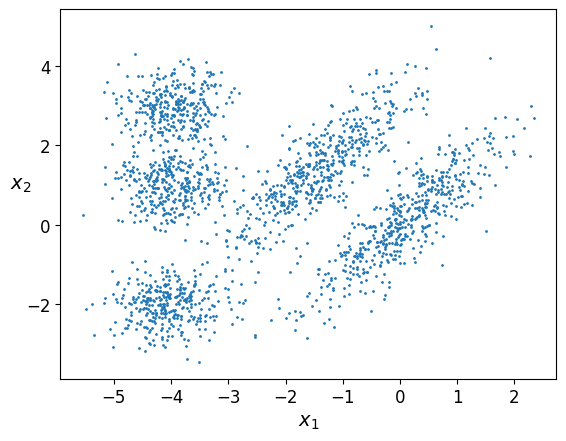

In [62]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


plt.figure()
plot_clusters(X)
plt.show()

## K-means from sklearn

In [46]:
Ks = range(2, 9)
kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(X) for k in Ks]

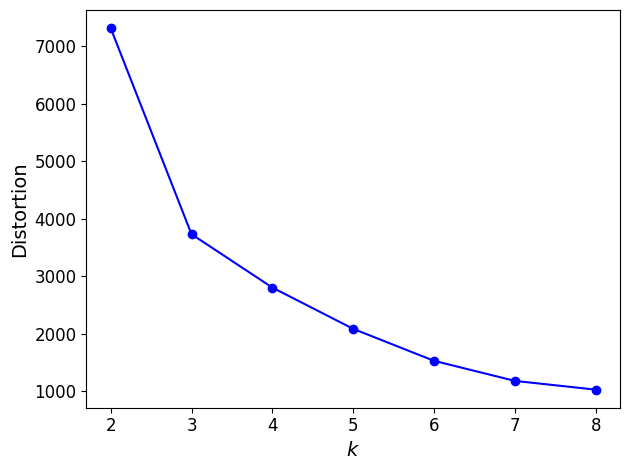

In [18]:
# inertia_: Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure()
plt.plot(Ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Distortion", fontsize=14)
if geron_data:
    plt.annotate(
        "Elbow",
        xy=(4, inertias[3]),
        xytext=(0.55, 0.55),
        textcoords="figure fraction",
        fontsize=16,
        arrowprops=dict(facecolor="black", shrink=0.1),
    )
plt.tight_layout()
plt.show()

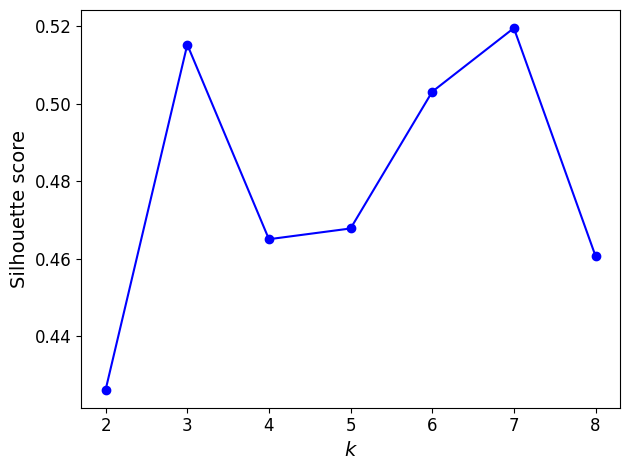

In [32]:
# labels_: Labels of each point
#
# silhouette_score: Compute the **mean** Silhouette Coefficient of all samples.
# Silhouette Coefficient for a sample: |(b - a) / max(a, b)|.
# where |a| is mean intra-cluster distance and |b| is the distance between a sample and the nearest cluster that the sample is not a part of.
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]

plt.figure()
plt.plot(Ks, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.tight_layout()
plt.show()

In [54]:
model = kmeans_per_k[0]
silhouette_coefficients = silhouette_samples(X, model.labels_)
silhouette_coefficients.mean(), silhouette_score(X, model.labels_), len(X)

(0.4262199477143357, 0.4262199477143357, 2000)

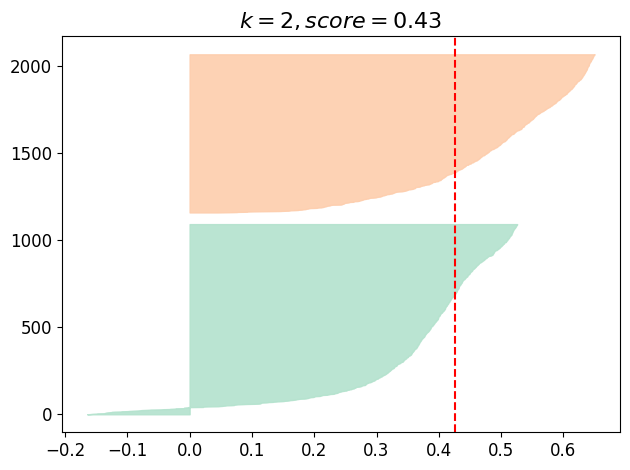

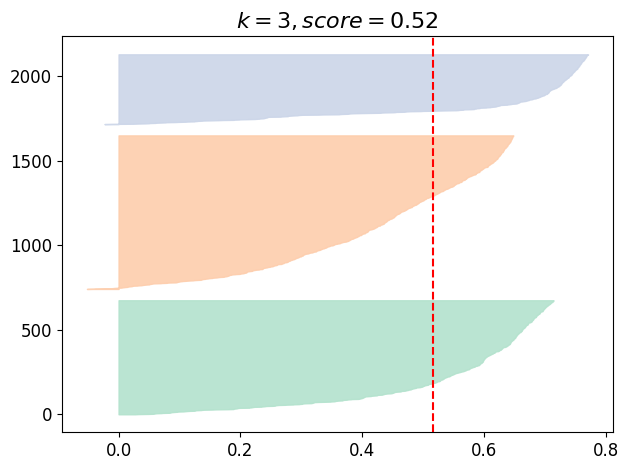

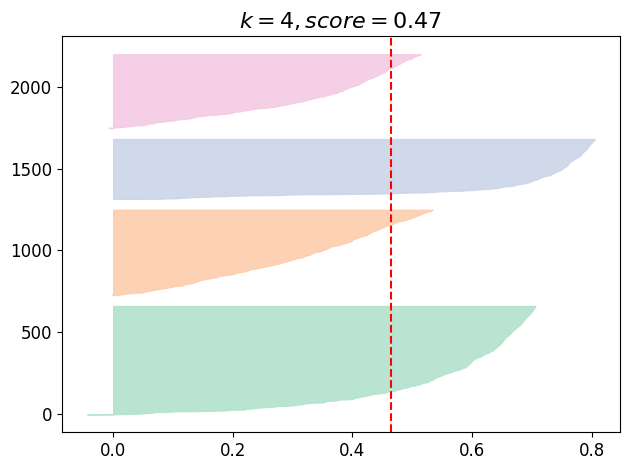

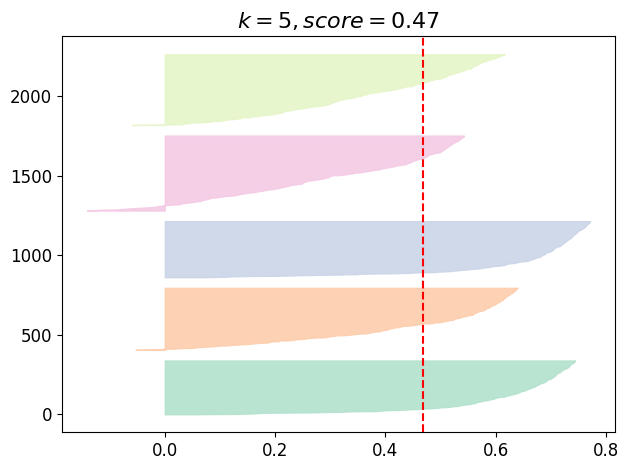

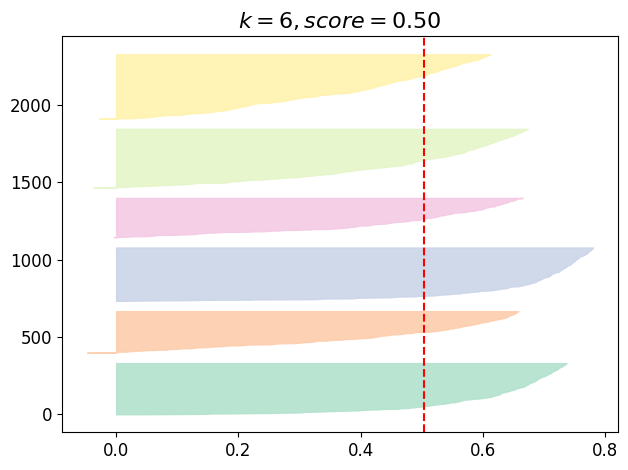

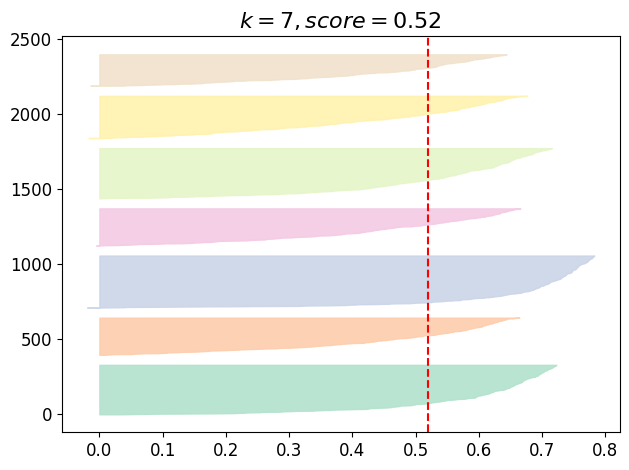

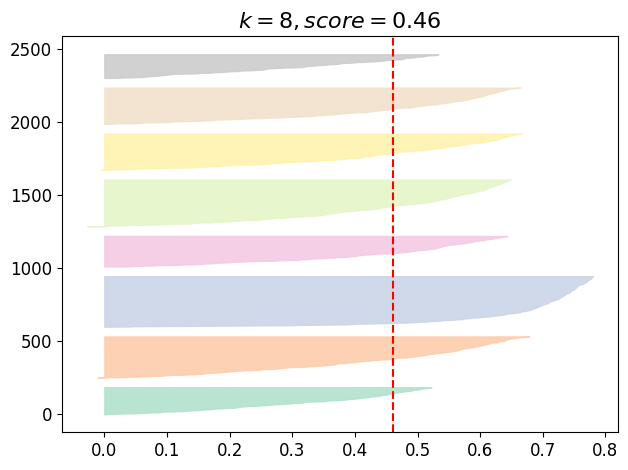

In [56]:
from sklearn.metrics import silhouette_samples
# silhouette_samples: Compute the Silhouette Coefficient for each sample.

def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    assert silhouette_coefficients.mean() == silhouette_scores

    cmap = plt.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]

    pos = 0
    padding = len(X) // 30
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.9)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)

for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_silhouette(model, X)
    plt.tight_layout()

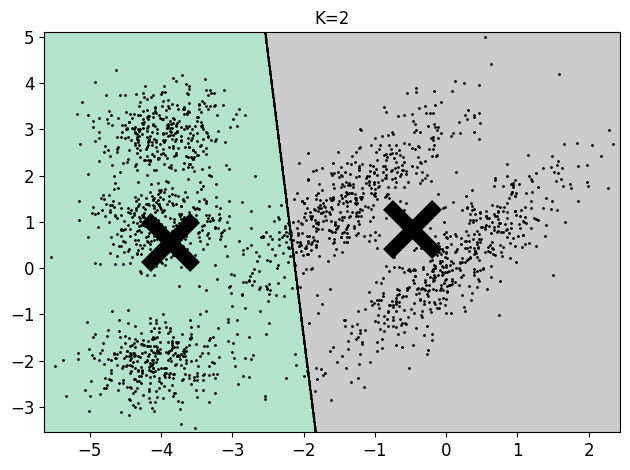

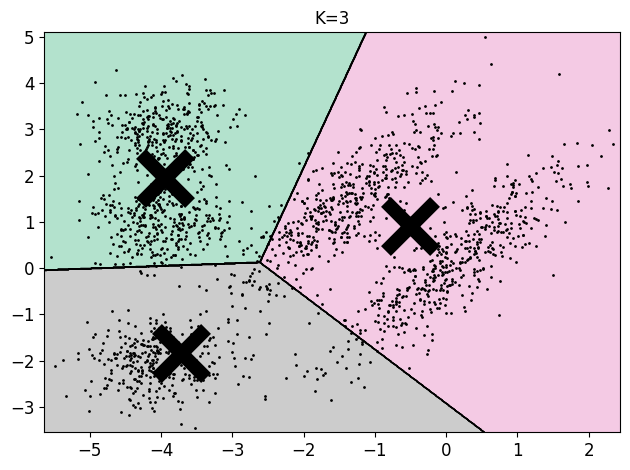

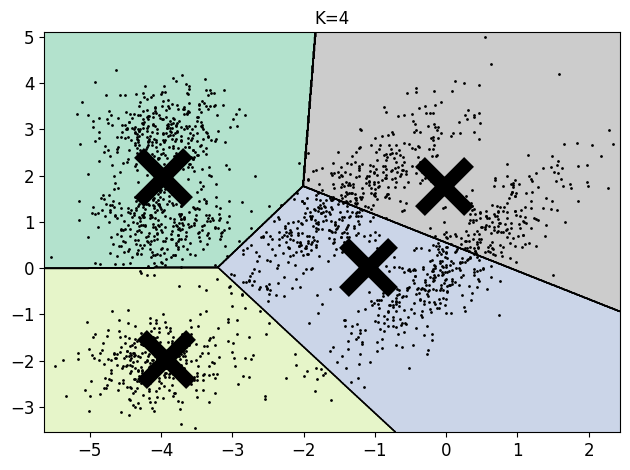

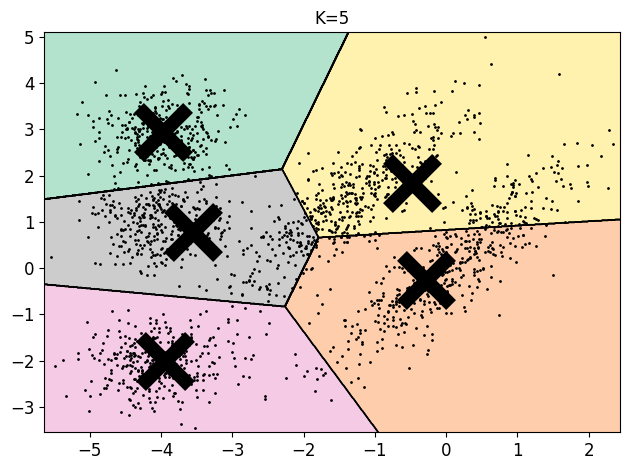

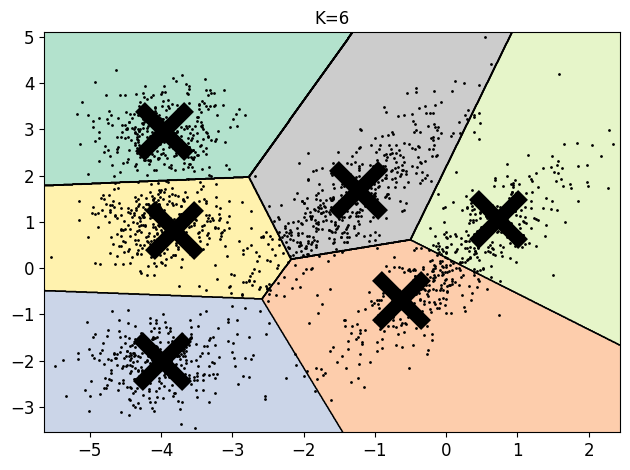

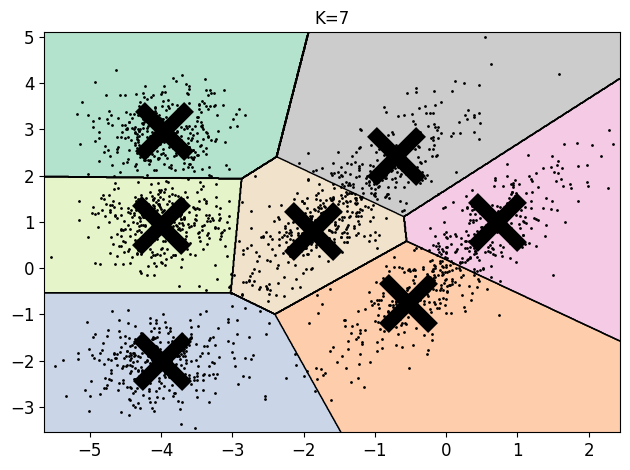

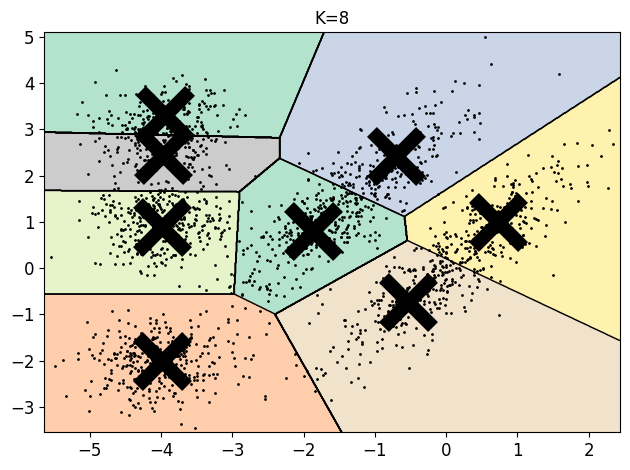

In [68]:
def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="o", s=30, linewidths=8, color=circle_color, zorder=10, alpha=0.9
    )
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="x", s=50, linewidths=50, color=cross_color, zorder=11, alpha=1
    )


def plot_decision_boundaries(model, X, resolution=1000, show_centroids=True):
    mu = model.cluster_centers_
    K, D = mu.shape
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    if show_centroids:
        plot_centroids(model.cluster_centers_)
    plt.title(f"K={K}")

for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_decision_boundaries(model, X)
    plt.tight_layout()


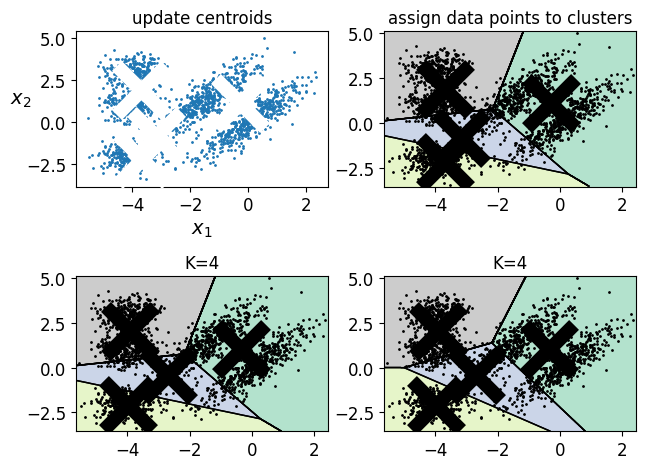

In [71]:
### Plot iterations of K means
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)

K = 4
seed = 1
kmeans_iter1 = KMeans(n_clusters=K, init="random", n_init=1, algorithm="lloyd", max_iter=1, random_state=seed)
kmeans_iter2 = KMeans(n_clusters=K, init="random", n_init=1, algorithm="lloyd", max_iter=2, random_state=seed)
kmeans_iter3 = KMeans(n_clusters=K, init="random", n_init=1, algorithm="lloyd", max_iter=3, random_state=seed)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure()
nr = 2
nc = 2

plt.subplot(nr, nc, 1)
plot_clusters(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color="r", cross_color="w")
plt.title("update centroids")

plt.subplot(nr, nc, 2)
plot_decision_boundaries(kmeans_iter1, X)
plt.title("assign data points to clusters")

plt.subplot(nr, nc, 3)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(nr, nc, 4)
plot_decision_boundaries(kmeans_iter2, X)

plt.tight_layout()
plt.show()

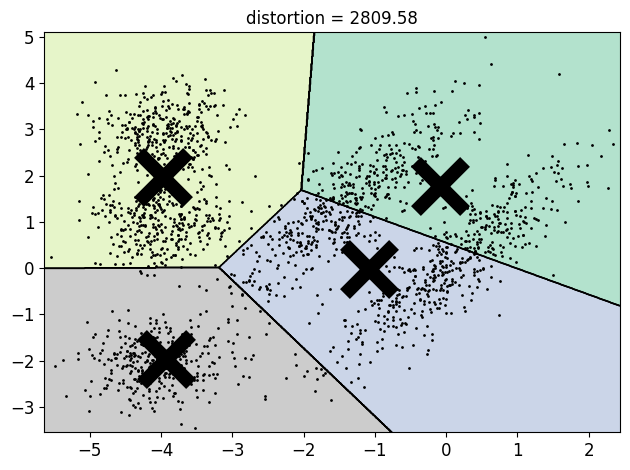

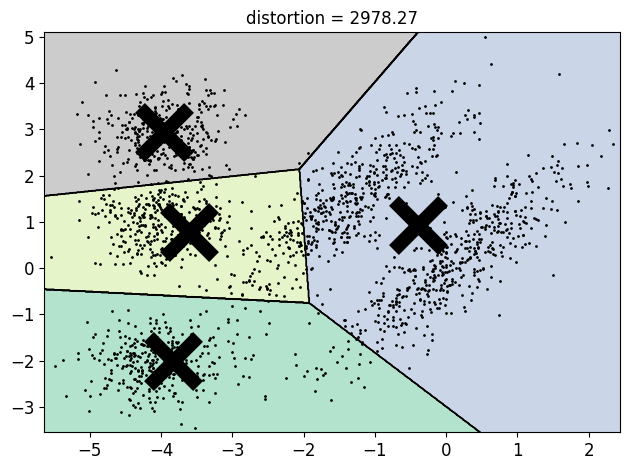

In [73]:
### K means variability
seeds = [2, 3]
for seed in seeds:
    model = KMeans(n_clusters=K, init="random", n_init=1, algorithm="lloyd", random_state=seed)
    model.fit(X)
    plt.figure()
    plot_decision_boundaries(model, X)
    loss = model.inertia_
    plt.title("distortion = {:0.2f}".format(loss, fontsize=14))
    plt.tight_layout()
    plt.show()

## K means from scratch

In [76]:
np.random.seed(42)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class myKMeans():

    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)


    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color='black', linewidth=2)

        plt.show()

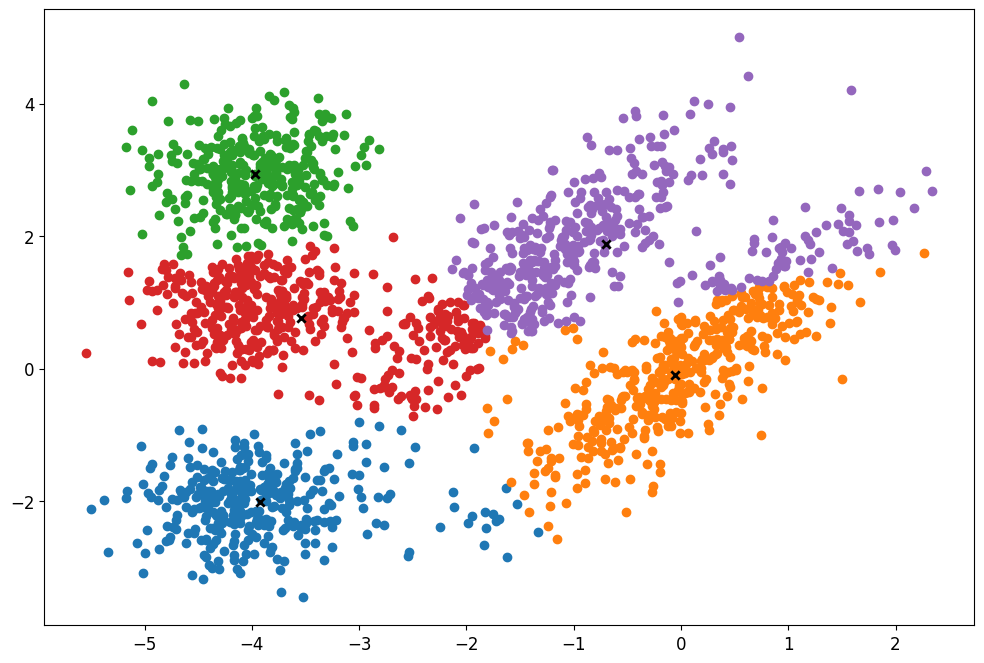

In [82]:
K = 5
model = myKMeans(K, max_iters=300, plot_steps=False)
y_pred = model.predict(X)
model.plot()